In [1]:
import math

# standards
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

# deep learning
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# learn process visualition
from livelossplot.inputs.tf_keras import PlotLossesCallback
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot

In [2]:
class DataSequence(Sequence):
    def __init__(self, x_set, y_set, train_size, validation_size):
        self.x_set, self.y_set = x_set, y_set
        self.train_size = train_size
        self.validation_size = validation_size
        self.batch_size = train_size + validation_size

    def __len__(self):
        return math.ceil(len(self.x_set) / self.batch_size)

    def __getitem__(self, index):
        min_bound, max_bound = self.get_bounds(index)
        batch_x = self.x_set[min_bound: max_bound]
        batch_y = self.y_set[min_bound: max_bound]
        return self._reshape(batch_x), self._reshape(batch_y)
    
    def _reshape(self, batch):
        return batch.reshape(-1, 1)
    
    def get_bounds(self, index):
        raise NotImplemented()
        

class TrainDataSequence(DataSequence):
    def get_bounds(self, index):
        min_bound = index * self.batch_size
        max_bound = index * self.batch_size + self.train_size
        return min_bound, max_bound
    
    
class ValidationDataSequence(DataSequence):
    def get_bounds(self, index):
        min_bound = index * self.batch_size + self.train_size
        max_bound = index * self.batch_size + self.batch_size
        return min_bound, max_bound


In [3]:
samples_no = 1000
df = pd.DataFrame({'x': [i for i in range(samples_no)], 'y': [i**2 for i in range(samples_no)]})
df = df.values
X, y = df[:,0], df[:,1]

In [4]:
num_rows = len(df)
validate_size = 5
train_size = 20
batch_size = validate_size + train_size
steps_per_epoch = 2
epochs = num_rows // batch_size // steps_per_epoch

In [5]:
# Create the model
model = Sequential()
model.add(Dense(32, input_dim=1, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(loss='mse',
              optimizer=Adam(),
              metrics=['mae'])

In [6]:
plotlosses = PlotLosses()

In [7]:
validation_generator = ValidationDataSequence(
    x_set=X, y_set=y, train_size=train_size, validation_size=validate_size
)

train_generator = TrainDataSequence(
    x_set=X, y_set=y, train_size=train_size, validation_size=validate_size
)

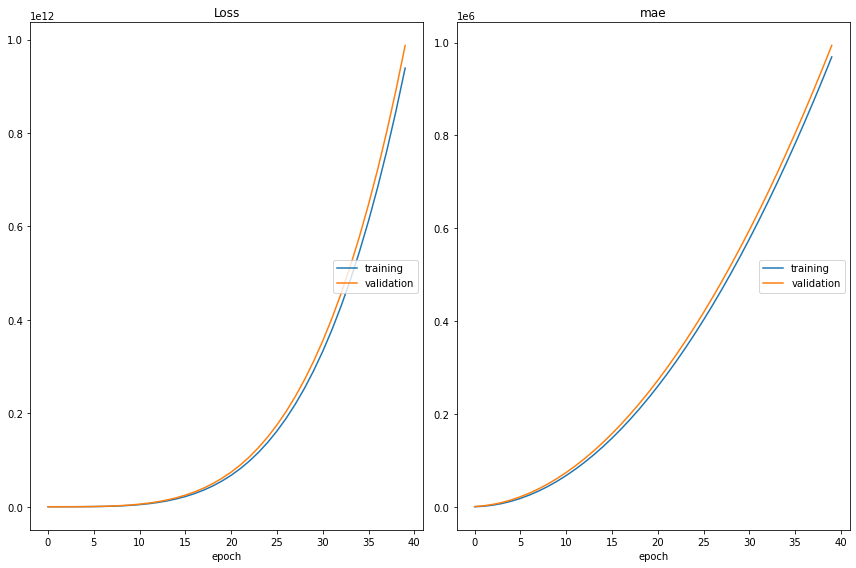

Loss
	training         	 (min: 27853.131, max: 939122819072.000, cur: 939122819072.000)
	validation       	 (min: 238309.547, max: 987534393344.000, cur: 987534393344.000)
mae
	training         	 (min:  122.761, max: 969017.000, cur: 969017.000)
	validation       	 (min:  484.199, max: 993743.688, cur: 993743.688)


In [8]:
for train, validation in zip(train_generator, validation_generator):
    x_train, y_train = train
    history = model.fit(
        x_train, 
        y_train,
        validation_data=validation,
    )

    unpacked_history = {
        key: value[0]
        for key, value in history.history.items()
    }    
    plotlosses.update(unpacked_history)
    plotlosses.send()  # draw, update logs, etc
